# Test 2D Levy flight in a switching fitness landscape
<!-- ## The flights in each dimension are dependent -->

Potential interpolated from grid data, `./input/landscape1.csv` and `./input/landscape2.csv`
Grid data for potential taken from `/home/ochab/Dropbox/backup/ecoli/maple/fitness_new03a.mw`

# See previous notebooks for other results

## Definitions

In [1]:
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
import pandas as pd
import random
import time
from run import run

In [2]:
def generate_ax_traj(ax:plt.axes, trajdf:pd.DataFrame) -> None:    
    """Generate plt.axes object that plots a trajectory saved in trajdf.

    Args:
        ax (plt.axes): Plot content
        trajdf (pd.DataFrame): Trajectory data frame with columns: 'x' and 'y'
    """    
    if trajdf is not None:
            ax.plot(trajdf.x,trajdf.y, color='black')
    return


def generate_ax_pcolormesh(
        fig:plt.figure, 
        ax:plt.axes, 
        axtitle:str, 
        df:pd.DataFrame, 
        z_column:str, 
        fmin:float, 
        fmax:float
        )-> None:
    """Generate plt.axes object that plots a colormesh.

    Args:
        fig (plt.figure): Figure (needed for colorbar() (???))
        ax (plt.axes): Plot content
        axtitle (str): Plot title
        df (pd.DataFrame): Dataframe with columns: x='kmr', y='kr', z=z_column
        z_column (str): z column title
        fmin (float): Minimal z value of the color mesh
        fmax (float): Maximal z value of the color mesh
    """        
    nx = int( df['kmr'].max() - df['kmr'].min() + 1)
    ny = int( df['kr'].max() - df['kr'].min() + 1)

    x = df['kmr'].values.reshape(nx,ny).T
    y = df['kr'].values.reshape(nx,ny).T
    z = df[z_column].values.reshape(nx,ny).T

    c = ax.pcolormesh(x,y,z,vmin=fmin, vmax=fmax, cmap = plt.cm.jet)

    ax.set_title(axtitle)
    ax.set_xlabel('kmr')
    ax.set_ylabel('kr')
    fig.colorbar(c , ax=ax) 
    return

def plot_figures(
        dflist:list, 
        z_column:str, 
        fmin:list=[], 
        fmax:list=[],
        trajdf:pd.DataFrame=None
        )-> None:
    """Plot any number of figures side by side.

    Args:
        dflist (list): List of dataframes containing the color mesh data
        z_column (str): z column title for the dataframes containing the color mesh data
        fmin (list, optional): Minimal z value of the color mesh. Defaults to [].
        fmax (list, optional): Maximal z value of the color mesh. Defaults to [].
        trajdf (pd.DataFrame, optional): Trajectory data frame with columns: 'x' and 'y'. Defaults to None.
    """    
    fig, ax = plt.subplots(1,len(dflist),  figsize=(4.5*len(dflist), 3))

    for i in range (len(dflist)):
        if len(dflist)==1:
            Ax=ax
            title = z_column
        else:  
            Ax = ax[i]
            title = z_column+str(i)

        if len(fmin)>0:
            v_min=fmin[i]
        else:
            v_min=None
        if len(fmax)>0:
            v_max=fmax[i]
        else:
            v_max=None    

        generate_ax_traj(ax=Ax, trajdf=trajdf)
    
        generate_ax_pcolormesh(
            fig=fig, 
            ax=Ax, 
            axtitle=title, 
            df=dflist[i], 
            z_column=z_column, 
            fmin=v_min, 
            fmax=v_max
            )

    plt.show()
    return

In [3]:
input_dir="./input/"
input_data_file1 = "landscape1.csv"
input_data_file2 = "landscape2.csv"
input_data_files=[input_data_file1,input_data_file2]
potentialfile1 = input_dir+input_data_file1
potentialfile2 = input_dir+input_data_file2
output_dir="./output/"
output_log_file="out.log"

In [4]:
Ndatafiles=2
dfv=[]
for i in range (Ndatafiles):
    dfv.append(pd.read_csv(input_dir+input_data_files[i]))

In [5]:
display(dfv[0])
display(dfv[1])

,kmr,kr,fitness
0,1.0,1.0,-574.1
1,1.0,2.0,-573.2
2,1.0,3.0,-572.3
3,1.0,4.0,-571.4
4,1.0,5.0,-570.5
...,...,...,...
9995,100.0,96.0,6202.0
9996,100.0,97.0,6292.0
9997,100.0,98.0,6382.0
9998,100.0,99.0,6472.0


,kmr,kr,fitness
0,1.0,1.0,-23575.0
1,1.0,2.0,-23575.0
2,1.0,3.0,-23575.0
3,1.0,4.0,-23575.0
4,1.0,5.0,-23575.0
...,...,...,...
9995,100.0,96.0,-22822.0
9996,100.0,97.0,-22812.0
9997,100.0,98.0,-22802.0
9998,100.0,99.0,-22792.0


Until now, we have had the potential landscape (optimum=minimum): `dfv`

For plotting, we prefer the data as a fitness landscape (optimum=maximum): `dff`

## Convert potential landscape to fitness landscape

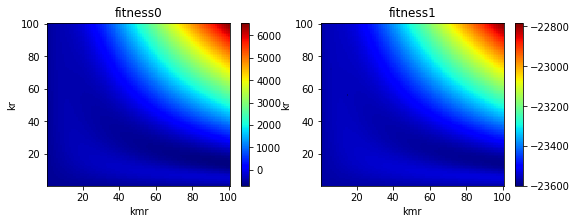

In [6]:
plot_figures(dfv, z_column='fitness')

These are potential landscapes. Max fitness = min potential.

We create `dff`: fitness landscape = -potential:

In [7]:
# Real copy
dff=[df.copy(deep=True) for df in dfv]
for df in dff:
    df['fitness']=-df['fitness']

## Run simulation

In [8]:
T1=1000.0
Ntraj1=1
dt1= 0.1 #0.001
minDt = 0. #1e-1
eta=0.1
D = 2. #1. #0.1
gamma = 1. #0.5
# alpha= # Will be given below
x0=5.
y0=5.
kr1=10.
kr2=20.
kmr1=90.
kmr2=100.

In [9]:
def test_alpha_param(alpha:float)->None:
   """Test simulation trajectories with a chosen value of the Levy flight parameter alpha.
   The function generates plots of the trajectory vs. time and the trajectory on the background of 
   two fitness landscapes (landscape 0 and landscape 1 switched in time during the simulation).

   Args:
       alpha (float): Levy flight parameter
   """

   output_data_file=f"outT{T1:.0e}N{Ntraj1:.0e}dt{dt1:.0e}_single_traj.csv"
   random.seed(time.time())
   run(
      output_dir,
      output_data_file,
      output_log_file,
      alpha=alpha, 
      D=D,
      gamma = gamma,
      dt=dt1, 
      minDt=minDt,
      eta=eta,
      T=T1, 
      t0=0., 
      x0=x0,
      y0=y0,
      kmr1=kmr1,
      kmr2=kmr2,
      kr1=kr1,
      kr2=kr2,
      Ntraj=Ntraj1,
      seed = random.randrange(100000), #785130160,
      potentialfile=potentialfile1,
      potentialfile_second=potentialfile2
      )



   print(open('./output/out.log', 'r').read()) 


   df=pd.read_csv(output_dir+output_data_file)

   fig, ax = plt.subplots(1,1)
   ax.plot(df.t, df.x , label=f"kmr, dt={dt1}")
   ax.plot(df.t, df.y , label=f"kr, dt={dt1}")
   ax.legend(loc='best', frameon=False)
   ax.set_xlabel("t")
   ax.set_ylabel("kmr, kr")
   f=[dff[i]['fitness'].iloc[0] -(dff[i]['fitness'].max()-dff[i]['fitness'].min())/15 \
      for i in range(Ndatafiles)]

   fmin=np.array(f)

   fmax=fmin+700
   plt.show()


   f=[dff[i]['fitness'].iloc[0] -(dff[i]['fitness'].max()-dff[i]['fitness'].min())/15 \
      for i in range(Ndatafiles)]

   fmin=np.array(f)

   fmax=fmin+700

   plot_figures(dflist=dff, z_column='fitness',fmin=fmin, fmax=fmax, trajdf=df)
   return

Trajectories are supposed to stop at the square ((10,20),(90,100)).

## Generate ensemble of trajectories

In [10]:
def run_ensemble_simulation(alpha:float, T:float, Ntraj:int)->str:
    """Run ensemble simulation with a chosen value of the Levy flight parameter alpha.  
    The simulation switches landscape 0 and landscape 1 in time.
    The function generates a file with columns: t,x,y. t: simulation end (here: when
    the trajectory reaches the square ((kmr1,kmr2),(kr1,kr2))). x,y: coordinates of the
    last point of the trajectory.

    Args:
        alpha (float): Levy flight parameter
        T (float): max simulation time
        Ntraj (int) : number of trajectories in the ensemble
    Returns:
        output_data_file (str):
    """   
    output_data_file=f"outT{T1:.0e}N{Ntraj1:.0e}dt{dt1:.0e}alpha{alpha:.0e}_ensemble.csv"
    random.seed(time.time())
    
    run(
        output_dir,
        output_data_file,
        output_log_file,
        alpha=alpha, 
        D=D,
        gamma = gamma,
        dt=dt1, 
        minDt=minDt,
        eta=eta,
        T=T, 
        t0=0., 
        x0=x0,
        y0=y0,
        kmr1=kmr1,
        kmr2=kmr2,
        kr1=kr1,
        kr2=kr2,
        Ntraj=Ntraj,
        seed = random.randrange(100000),# 785130169,
        potentialfile=potentialfile1,
        potentialfile_second=potentialfile2
    )

    print(open('./output/out.log', 'r').read()) 
    return output_data_file


def plot_heatmap(output_data_file:str, alpha:float)->None:
    """Plot heatmap from the output data file columns x,y.

    Args:
        output_data_file (str):
        alpha (float): alpha parameter
    """    
    ensdf=pd.read_csv(output_dir+output_data_file)
    fig, ax = plt.subplots(1,1)
    Nbins = 100
    x_bins = np.linspace(0, 100, Nbins)
    y_bins = np.linspace(0, 100, Nbins)
    h = ax.hist2d(np.array(ensdf.x), np.array(ensdf.y), bins =[x_bins, y_bins], cmap = plt.cm.jet) 
    # nipy_spectral
    fig.colorbar(h[3] , ax=ax) 
    ax.set_xlabel('kmr')
    ax.set_ylabel('kr')
    ax.set_title("alpha={:.1f}".format(alpha))

    plt.tight_layout() 
    plt.show()
    return

def plot_fpt_hist(output_data_file:str, alpha:float)->tuple:
    """Plot a histogram from the output_data_file's 't' column.

    Args:
        output_data_file (str):
        alpha (float): alpha parameter

    Returns:
        (float, float): ('t' column mean, 't' column std dev)
    """    
    ensdf=pd.read_csv(output_dir+output_data_file)
    fig,ax=plt.subplots(1,1)
    plt.hist(ensdf['t'], bins=30, density=True)

    x_label = 'Time to reach the maximum region (({:.0f},{:.0f}),({:.0f},{:.0f})), T'.format(kmr1,kmr2,kr1,kr2)

    ax.set_xlabel(x_label) 
    ax.set_ylabel('Probability')  
    ax.set_title("alpha={:.1f}".format(alpha))  
    plt.show()     
    return


def get_fpt_mean_sd(output_data_file:str)->tuple:
    """Get 't' column mean, 't' column std dev from the file
    Args:
        output_data_file (str):

    Returns:
        (float, float): ('t' column mean, 't' column std dev)
    """       
    ensdf=pd.read_csv(output_dir+output_data_file)
    return(ensdf['t'].mean(), ensdf['t'].std())              


# Calculate MFPT vs. $\alpha$

WARNING: This simulation will take some time!


alpha = 0.1
D = 2
gamma = 1
dt = 0.1
minDt = 0
eta = 0.1
T = 5000
t0 = 0
x0 = 5
y0 = 5
potential_file = ./input/landscape1.csv
potential_file_second = ./input/landscape2.csv
kmr1 = 90
kmr2 = 100
kr1 = 10
kr2 = 20
seed = 30516
Ntraj = 100
Only end points of the 100 trajectories will be printed as the output.
Running the simulation...

-------------launch_2D_ensemble_potential_file()-----------
potential_file=./input/landscape1.csv
potential_file_second=./input/landscape2.csv
Average time of simulation: 52.9728
Time simulation variance: 1977.21
Output written to STDOUT.
Done.

alpha = 0.1
D = 2
gamma = 1
dt = 0.1
minDt = 0
eta = 0.1
T = 5000
t0 = 0
x0 = 5
y0 = 5
potential_file = ./input/landscape1.csv
potential_file_second = ./input/landscape2.csv
kmr1 = 90
kmr2 = 100
kr1 = 10
kr2 = 20
seed = 32143
Ntraj = 100
Only end points of the 100 trajectories will be printed as the output.
Running the simulation...

-------------launch_2D_ensemble_potential_file()-----------
potential_file=./input

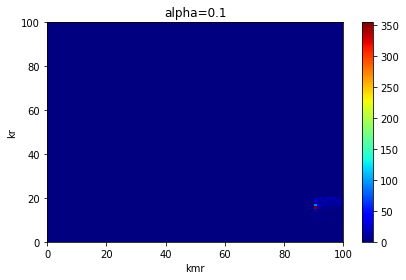

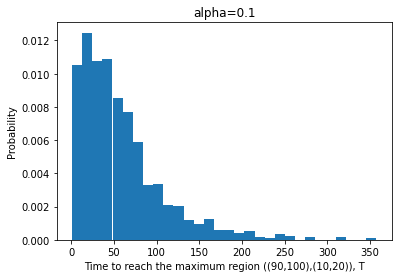

alpha = 0.1
D = 2
gamma = 1
dt = 0.1
minDt = 0
eta = 0.1
T = 5000
t0 = 0
x0 = 5
y0 = 5
potential_file = ./input/landscape1.csv
potential_file_second = ./input/landscape2.csv
kmr1 = 90
kmr2 = 100
kr1 = 10
kr2 = 20
seed = 30516
Ntraj = 100
Only end points of the 100 trajectories will be printed as the output.
Running the simulation...

-------------launch_2D_ensemble_potential_file()-----------
potential_file=./input/landscape1.csv
potential_file_second=./input/landscape2.csv
Average time of simulation: 52.9728
Time simulation variance: 1977.21
Output written to STDOUT.
Done.

alpha = 0.1
D = 2
gamma = 1
dt = 0.1
minDt = 0
eta = 0.1
T = 5000
t0 = 0
x0 = 5
y0 = 5
potential_file = ./input/landscape1.csv
potential_file_second = ./input/landscape2.csv
kmr1 = 90
kmr2 = 100
kr1 = 10
kr2 = 20
seed = 32143
Ntraj = 100
Only end points of the 100 trajectories will be printed as the output.
Running the simulation...

-------------launch_2D_ensemble_potential_file()-----------
potential_file=./input

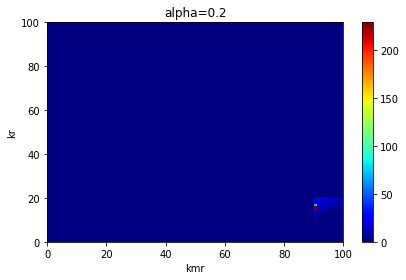

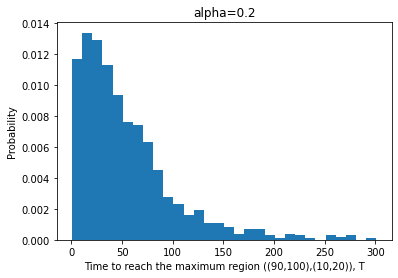

alpha = 0.1
D = 2
gamma = 1
dt = 0.1
minDt = 0
eta = 0.1
T = 5000
t0 = 0
x0 = 5
y0 = 5
potential_file = ./input/landscape1.csv
potential_file_second = ./input/landscape2.csv
kmr1 = 90
kmr2 = 100
kr1 = 10
kr2 = 20
seed = 30516
Ntraj = 100
Only end points of the 100 trajectories will be printed as the output.
Running the simulation...

-------------launch_2D_ensemble_potential_file()-----------
potential_file=./input/landscape1.csv
potential_file_second=./input/landscape2.csv
Average time of simulation: 52.9728
Time simulation variance: 1977.21
Output written to STDOUT.
Done.

alpha = 0.1
D = 2
gamma = 1
dt = 0.1
minDt = 0
eta = 0.1
T = 5000
t0 = 0
x0 = 5
y0 = 5
potential_file = ./input/landscape1.csv
potential_file_second = ./input/landscape2.csv
kmr1 = 90
kmr2 = 100
kr1 = 10
kr2 = 20
seed = 32143
Ntraj = 100
Only end points of the 100 trajectories will be printed as the output.
Running the simulation...

-------------launch_2D_ensemble_potential_file()-----------
potential_file=./input

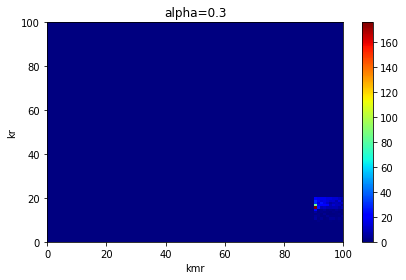

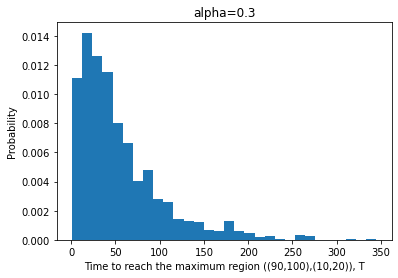

alpha = 0.1
D = 2
gamma = 1
dt = 0.1
minDt = 0
eta = 0.1
T = 5000
t0 = 0
x0 = 5
y0 = 5
potential_file = ./input/landscape1.csv
potential_file_second = ./input/landscape2.csv
kmr1 = 90
kmr2 = 100
kr1 = 10
kr2 = 20
seed = 30516
Ntraj = 100
Only end points of the 100 trajectories will be printed as the output.
Running the simulation...

-------------launch_2D_ensemble_potential_file()-----------
potential_file=./input/landscape1.csv
potential_file_second=./input/landscape2.csv
Average time of simulation: 52.9728
Time simulation variance: 1977.21
Output written to STDOUT.
Done.

alpha = 0.1
D = 2
gamma = 1
dt = 0.1
minDt = 0
eta = 0.1
T = 5000
t0 = 0
x0 = 5
y0 = 5
potential_file = ./input/landscape1.csv
potential_file_second = ./input/landscape2.csv
kmr1 = 90
kmr2 = 100
kr1 = 10
kr2 = 20
seed = 32143
Ntraj = 100
Only end points of the 100 trajectories will be printed as the output.
Running the simulation...

-------------launch_2D_ensemble_potential_file()-----------
potential_file=./input

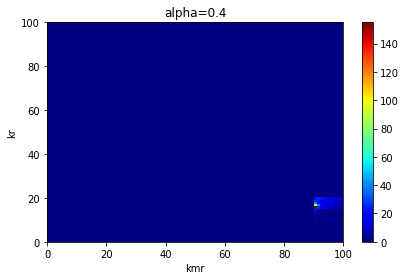

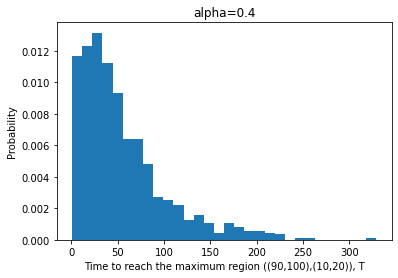

alpha = 0.1
D = 2
gamma = 1
dt = 0.1
minDt = 0
eta = 0.1
T = 5000
t0 = 0
x0 = 5
y0 = 5
potential_file = ./input/landscape1.csv
potential_file_second = ./input/landscape2.csv
kmr1 = 90
kmr2 = 100
kr1 = 10
kr2 = 20
seed = 30516
Ntraj = 100
Only end points of the 100 trajectories will be printed as the output.
Running the simulation...

-------------launch_2D_ensemble_potential_file()-----------
potential_file=./input/landscape1.csv
potential_file_second=./input/landscape2.csv
Average time of simulation: 52.9728
Time simulation variance: 1977.21
Output written to STDOUT.
Done.

alpha = 0.1
D = 2
gamma = 1
dt = 0.1
minDt = 0
eta = 0.1
T = 5000
t0 = 0
x0 = 5
y0 = 5
potential_file = ./input/landscape1.csv
potential_file_second = ./input/landscape2.csv
kmr1 = 90
kmr2 = 100
kr1 = 10
kr2 = 20
seed = 32143
Ntraj = 100
Only end points of the 100 trajectories will be printed as the output.
Running the simulation...

-------------launch_2D_ensemble_potential_file()-----------
potential_file=./input

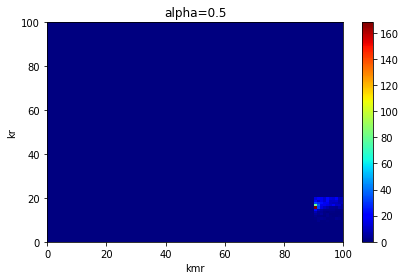

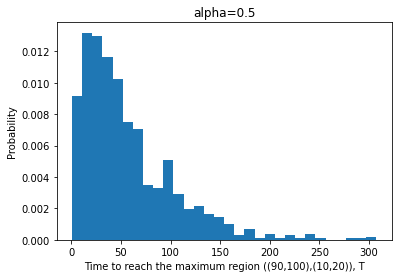

alpha = 0.1
D = 2
gamma = 1
dt = 0.1
minDt = 0
eta = 0.1
T = 5000
t0 = 0
x0 = 5
y0 = 5
potential_file = ./input/landscape1.csv
potential_file_second = ./input/landscape2.csv
kmr1 = 90
kmr2 = 100
kr1 = 10
kr2 = 20
seed = 30516
Ntraj = 100
Only end points of the 100 trajectories will be printed as the output.
Running the simulation...

-------------launch_2D_ensemble_potential_file()-----------
potential_file=./input/landscape1.csv
potential_file_second=./input/landscape2.csv
Average time of simulation: 52.9728
Time simulation variance: 1977.21
Output written to STDOUT.
Done.

alpha = 0.1
D = 2
gamma = 1
dt = 0.1
minDt = 0
eta = 0.1
T = 5000
t0 = 0
x0 = 5
y0 = 5
potential_file = ./input/landscape1.csv
potential_file_second = ./input/landscape2.csv
kmr1 = 90
kmr2 = 100
kr1 = 10
kr2 = 20
seed = 32143
Ntraj = 100
Only end points of the 100 trajectories will be printed as the output.
Running the simulation...

-------------launch_2D_ensemble_potential_file()-----------
potential_file=./input

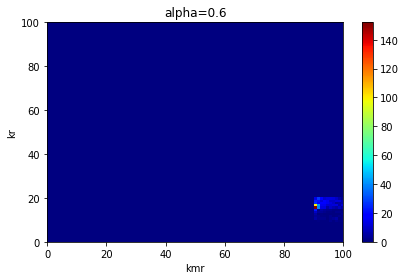

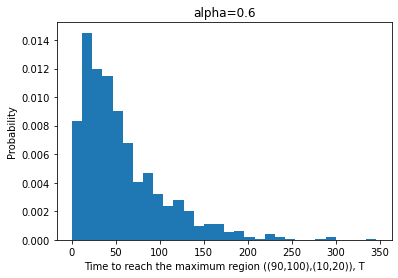

alpha = 0.1
D = 2
gamma = 1
dt = 0.1
minDt = 0
eta = 0.1
T = 5000
t0 = 0
x0 = 5
y0 = 5
potential_file = ./input/landscape1.csv
potential_file_second = ./input/landscape2.csv
kmr1 = 90
kmr2 = 100
kr1 = 10
kr2 = 20
seed = 30516
Ntraj = 100
Only end points of the 100 trajectories will be printed as the output.
Running the simulation...

-------------launch_2D_ensemble_potential_file()-----------
potential_file=./input/landscape1.csv
potential_file_second=./input/landscape2.csv
Average time of simulation: 52.9728
Time simulation variance: 1977.21
Output written to STDOUT.
Done.

alpha = 0.1
D = 2
gamma = 1
dt = 0.1
minDt = 0
eta = 0.1
T = 5000
t0 = 0
x0 = 5
y0 = 5
potential_file = ./input/landscape1.csv
potential_file_second = ./input/landscape2.csv
kmr1 = 90
kmr2 = 100
kr1 = 10
kr2 = 20
seed = 32143
Ntraj = 100
Only end points of the 100 trajectories will be printed as the output.
Running the simulation...

-------------launch_2D_ensemble_potential_file()-----------
potential_file=./input

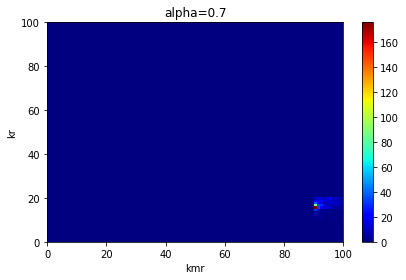

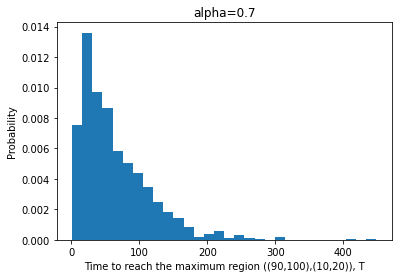

alpha = 0.1
D = 2
gamma = 1
dt = 0.1
minDt = 0
eta = 0.1
T = 5000
t0 = 0
x0 = 5
y0 = 5
potential_file = ./input/landscape1.csv
potential_file_second = ./input/landscape2.csv
kmr1 = 90
kmr2 = 100
kr1 = 10
kr2 = 20
seed = 30516
Ntraj = 100
Only end points of the 100 trajectories will be printed as the output.
Running the simulation...

-------------launch_2D_ensemble_potential_file()-----------
potential_file=./input/landscape1.csv
potential_file_second=./input/landscape2.csv
Average time of simulation: 52.9728
Time simulation variance: 1977.21
Output written to STDOUT.
Done.

alpha = 0.1
D = 2
gamma = 1
dt = 0.1
minDt = 0
eta = 0.1
T = 5000
t0 = 0
x0 = 5
y0 = 5
potential_file = ./input/landscape1.csv
potential_file_second = ./input/landscape2.csv
kmr1 = 90
kmr2 = 100
kr1 = 10
kr2 = 20
seed = 32143
Ntraj = 100
Only end points of the 100 trajectories will be printed as the output.
Running the simulation...

-------------launch_2D_ensemble_potential_file()-----------
potential_file=./input

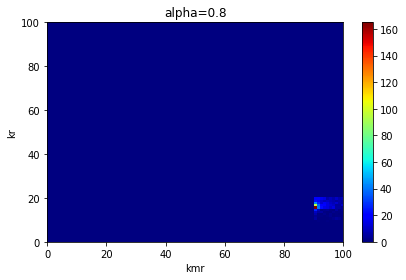

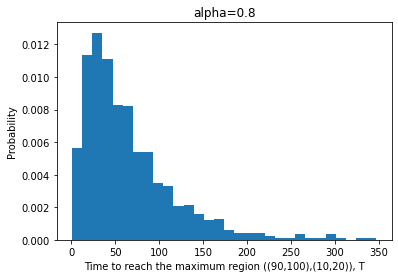

alpha = 0.1
D = 2
gamma = 1
dt = 0.1
minDt = 0
eta = 0.1
T = 5000
t0 = 0
x0 = 5
y0 = 5
potential_file = ./input/landscape1.csv
potential_file_second = ./input/landscape2.csv
kmr1 = 90
kmr2 = 100
kr1 = 10
kr2 = 20
seed = 30516
Ntraj = 100
Only end points of the 100 trajectories will be printed as the output.
Running the simulation...

-------------launch_2D_ensemble_potential_file()-----------
potential_file=./input/landscape1.csv
potential_file_second=./input/landscape2.csv
Average time of simulation: 52.9728
Time simulation variance: 1977.21
Output written to STDOUT.
Done.

alpha = 0.1
D = 2
gamma = 1
dt = 0.1
minDt = 0
eta = 0.1
T = 5000
t0 = 0
x0 = 5
y0 = 5
potential_file = ./input/landscape1.csv
potential_file_second = ./input/landscape2.csv
kmr1 = 90
kmr2 = 100
kr1 = 10
kr2 = 20
seed = 32143
Ntraj = 100
Only end points of the 100 trajectories will be printed as the output.
Running the simulation...

-------------launch_2D_ensemble_potential_file()-----------
potential_file=./input

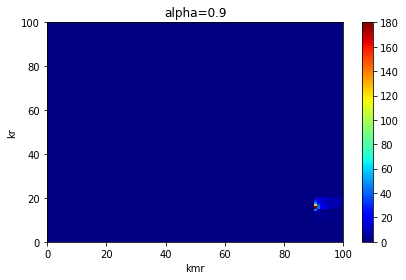

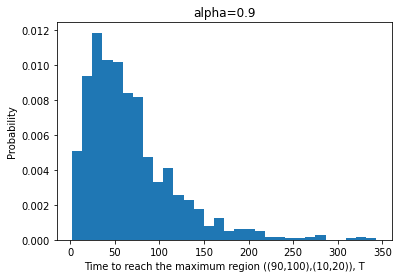

alpha = 0.1
D = 2
gamma = 1
dt = 0.1
minDt = 0
eta = 0.1
T = 5000
t0 = 0
x0 = 5
y0 = 5
potential_file = ./input/landscape1.csv
potential_file_second = ./input/landscape2.csv
kmr1 = 90
kmr2 = 100
kr1 = 10
kr2 = 20
seed = 30516
Ntraj = 100
Only end points of the 100 trajectories will be printed as the output.
Running the simulation...

-------------launch_2D_ensemble_potential_file()-----------
potential_file=./input/landscape1.csv
potential_file_second=./input/landscape2.csv
Average time of simulation: 52.9728
Time simulation variance: 1977.21
Output written to STDOUT.
Done.

alpha = 0.1
D = 2
gamma = 1
dt = 0.1
minDt = 0
eta = 0.1
T = 5000
t0 = 0
x0 = 5
y0 = 5
potential_file = ./input/landscape1.csv
potential_file_second = ./input/landscape2.csv
kmr1 = 90
kmr2 = 100
kr1 = 10
kr2 = 20
seed = 32143
Ntraj = 100
Only end points of the 100 trajectories will be printed as the output.
Running the simulation...

-------------launch_2D_ensemble_potential_file()-----------
potential_file=./input

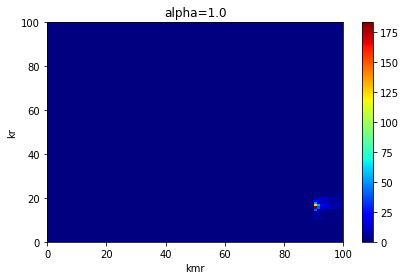

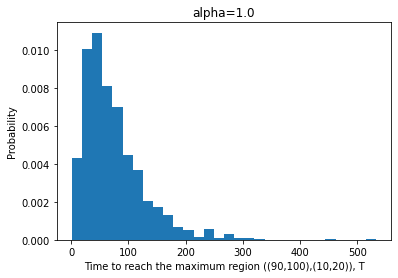

alpha = 0.1
D = 2
gamma = 1
dt = 0.1
minDt = 0
eta = 0.1
T = 5000
t0 = 0
x0 = 5
y0 = 5
potential_file = ./input/landscape1.csv
potential_file_second = ./input/landscape2.csv
kmr1 = 90
kmr2 = 100
kr1 = 10
kr2 = 20
seed = 30516
Ntraj = 100
Only end points of the 100 trajectories will be printed as the output.
Running the simulation...

-------------launch_2D_ensemble_potential_file()-----------
potential_file=./input/landscape1.csv
potential_file_second=./input/landscape2.csv
Average time of simulation: 52.9728
Time simulation variance: 1977.21
Output written to STDOUT.
Done.

alpha = 0.1
D = 2
gamma = 1
dt = 0.1
minDt = 0
eta = 0.1
T = 5000
t0 = 0
x0 = 5
y0 = 5
potential_file = ./input/landscape1.csv
potential_file_second = ./input/landscape2.csv
kmr1 = 90
kmr2 = 100
kr1 = 10
kr2 = 20
seed = 32143
Ntraj = 100
Only end points of the 100 trajectories will be printed as the output.
Running the simulation...

-------------launch_2D_ensemble_potential_file()-----------
potential_file=./input

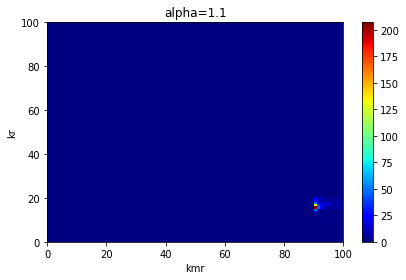

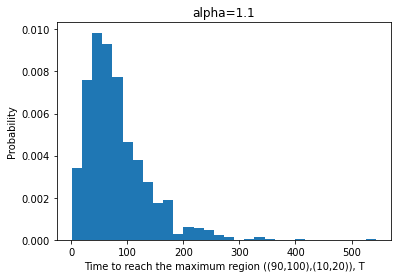

alpha = 0.1
D = 2
gamma = 1
dt = 0.1
minDt = 0
eta = 0.1
T = 5000
t0 = 0
x0 = 5
y0 = 5
potential_file = ./input/landscape1.csv
potential_file_second = ./input/landscape2.csv
kmr1 = 90
kmr2 = 100
kr1 = 10
kr2 = 20
seed = 30516
Ntraj = 100
Only end points of the 100 trajectories will be printed as the output.
Running the simulation...

-------------launch_2D_ensemble_potential_file()-----------
potential_file=./input/landscape1.csv
potential_file_second=./input/landscape2.csv
Average time of simulation: 52.9728
Time simulation variance: 1977.21
Output written to STDOUT.
Done.

alpha = 0.1
D = 2
gamma = 1
dt = 0.1
minDt = 0
eta = 0.1
T = 5000
t0 = 0
x0 = 5
y0 = 5
potential_file = ./input/landscape1.csv
potential_file_second = ./input/landscape2.csv
kmr1 = 90
kmr2 = 100
kr1 = 10
kr2 = 20
seed = 32143
Ntraj = 100
Only end points of the 100 trajectories will be printed as the output.
Running the simulation...

-------------launch_2D_ensemble_potential_file()-----------
potential_file=./input

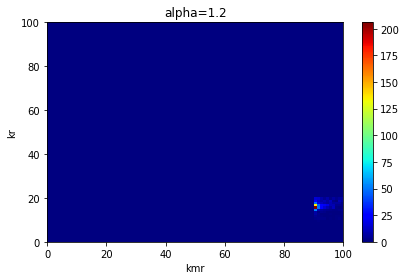

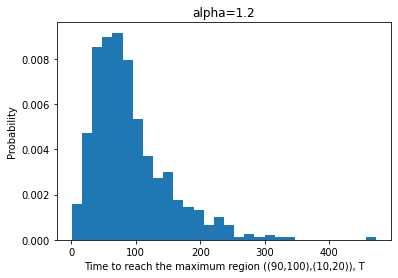

alpha = 0.1
D = 2
gamma = 1
dt = 0.1
minDt = 0
eta = 0.1
T = 5000
t0 = 0
x0 = 5
y0 = 5
potential_file = ./input/landscape1.csv
potential_file_second = ./input/landscape2.csv
kmr1 = 90
kmr2 = 100
kr1 = 10
kr2 = 20
seed = 30516
Ntraj = 100
Only end points of the 100 trajectories will be printed as the output.
Running the simulation...

-------------launch_2D_ensemble_potential_file()-----------
potential_file=./input/landscape1.csv
potential_file_second=./input/landscape2.csv
Average time of simulation: 52.9728
Time simulation variance: 1977.21
Output written to STDOUT.
Done.

alpha = 0.1
D = 2
gamma = 1
dt = 0.1
minDt = 0
eta = 0.1
T = 5000
t0 = 0
x0 = 5
y0 = 5
potential_file = ./input/landscape1.csv
potential_file_second = ./input/landscape2.csv
kmr1 = 90
kmr2 = 100
kr1 = 10
kr2 = 20
seed = 32143
Ntraj = 100
Only end points of the 100 trajectories will be printed as the output.
Running the simulation...

-------------launch_2D_ensemble_potential_file()-----------
potential_file=./input

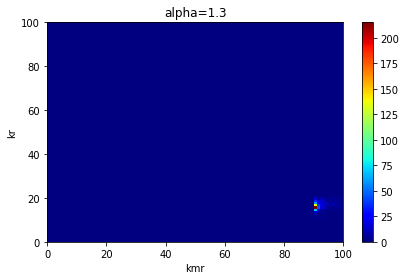

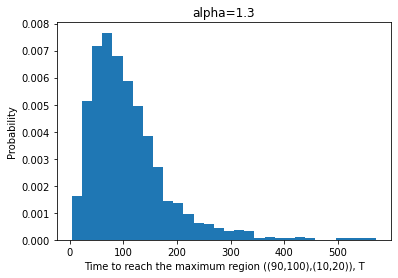

alpha = 0.1
D = 2
gamma = 1
dt = 0.1
minDt = 0
eta = 0.1
T = 5000
t0 = 0
x0 = 5
y0 = 5
potential_file = ./input/landscape1.csv
potential_file_second = ./input/landscape2.csv
kmr1 = 90
kmr2 = 100
kr1 = 10
kr2 = 20
seed = 30516
Ntraj = 100
Only end points of the 100 trajectories will be printed as the output.
Running the simulation...

-------------launch_2D_ensemble_potential_file()-----------
potential_file=./input/landscape1.csv
potential_file_second=./input/landscape2.csv
Average time of simulation: 52.9728
Time simulation variance: 1977.21
Output written to STDOUT.
Done.

alpha = 0.1
D = 2
gamma = 1
dt = 0.1
minDt = 0
eta = 0.1
T = 5000
t0 = 0
x0 = 5
y0 = 5
potential_file = ./input/landscape1.csv
potential_file_second = ./input/landscape2.csv
kmr1 = 90
kmr2 = 100
kr1 = 10
kr2 = 20
seed = 32143
Ntraj = 100
Only end points of the 100 trajectories will be printed as the output.
Running the simulation...

-------------launch_2D_ensemble_potential_file()-----------
potential_file=./input

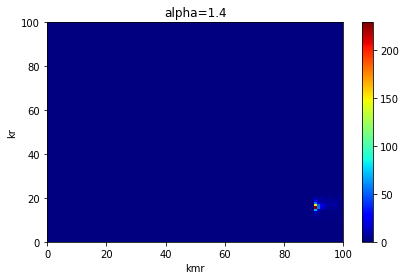

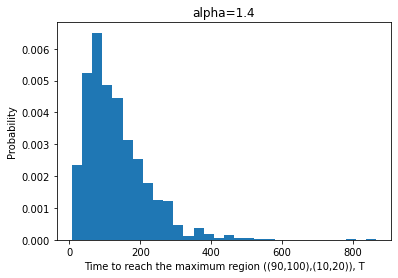

alpha = 0.1
D = 2
gamma = 1
dt = 0.1
minDt = 0
eta = 0.1
T = 5000
t0 = 0
x0 = 5
y0 = 5
potential_file = ./input/landscape1.csv
potential_file_second = ./input/landscape2.csv
kmr1 = 90
kmr2 = 100
kr1 = 10
kr2 = 20
seed = 30516
Ntraj = 100
Only end points of the 100 trajectories will be printed as the output.
Running the simulation...

-------------launch_2D_ensemble_potential_file()-----------
potential_file=./input/landscape1.csv
potential_file_second=./input/landscape2.csv
Average time of simulation: 52.9728
Time simulation variance: 1977.21
Output written to STDOUT.
Done.

alpha = 0.1
D = 2
gamma = 1
dt = 0.1
minDt = 0
eta = 0.1
T = 5000
t0 = 0
x0 = 5
y0 = 5
potential_file = ./input/landscape1.csv
potential_file_second = ./input/landscape2.csv
kmr1 = 90
kmr2 = 100
kr1 = 10
kr2 = 20
seed = 32143
Ntraj = 100
Only end points of the 100 trajectories will be printed as the output.
Running the simulation...

-------------launch_2D_ensemble_potential_file()-----------
potential_file=./input

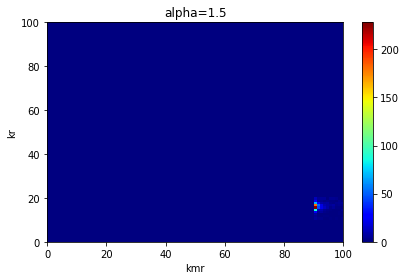

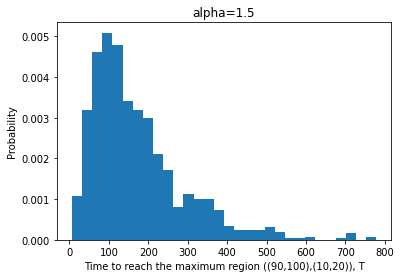

alpha = 0.1
D = 2
gamma = 1
dt = 0.1
minDt = 0
eta = 0.1
T = 5000
t0 = 0
x0 = 5
y0 = 5
potential_file = ./input/landscape1.csv
potential_file_second = ./input/landscape2.csv
kmr1 = 90
kmr2 = 100
kr1 = 10
kr2 = 20
seed = 30516
Ntraj = 100
Only end points of the 100 trajectories will be printed as the output.
Running the simulation...

-------------launch_2D_ensemble_potential_file()-----------
potential_file=./input/landscape1.csv
potential_file_second=./input/landscape2.csv
Average time of simulation: 52.9728
Time simulation variance: 1977.21
Output written to STDOUT.
Done.

alpha = 0.1
D = 2
gamma = 1
dt = 0.1
minDt = 0
eta = 0.1
T = 5000
t0 = 0
x0 = 5
y0 = 5
potential_file = ./input/landscape1.csv
potential_file_second = ./input/landscape2.csv
kmr1 = 90
kmr2 = 100
kr1 = 10
kr2 = 20
seed = 32143
Ntraj = 100
Only end points of the 100 trajectories will be printed as the output.
Running the simulation...

-------------launch_2D_ensemble_potential_file()-----------
potential_file=./input

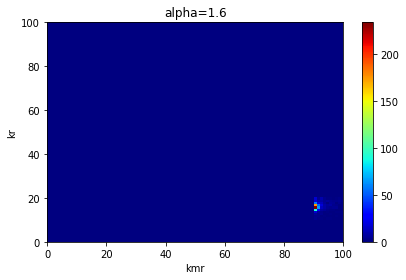

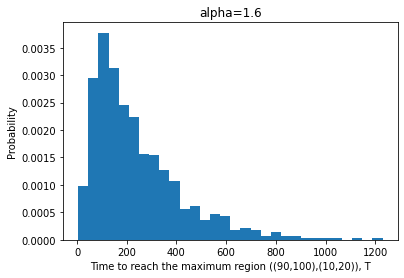

alpha = 0.1
D = 2
gamma = 1
dt = 0.1
minDt = 0
eta = 0.1
T = 5000
t0 = 0
x0 = 5
y0 = 5
potential_file = ./input/landscape1.csv
potential_file_second = ./input/landscape2.csv
kmr1 = 90
kmr2 = 100
kr1 = 10
kr2 = 20
seed = 30516
Ntraj = 100
Only end points of the 100 trajectories will be printed as the output.
Running the simulation...

-------------launch_2D_ensemble_potential_file()-----------
potential_file=./input/landscape1.csv
potential_file_second=./input/landscape2.csv
Average time of simulation: 52.9728
Time simulation variance: 1977.21
Output written to STDOUT.
Done.

alpha = 0.1
D = 2
gamma = 1
dt = 0.1
minDt = 0
eta = 0.1
T = 5000
t0 = 0
x0 = 5
y0 = 5
potential_file = ./input/landscape1.csv
potential_file_second = ./input/landscape2.csv
kmr1 = 90
kmr2 = 100
kr1 = 10
kr2 = 20
seed = 32143
Ntraj = 100
Only end points of the 100 trajectories will be printed as the output.
Running the simulation...

-------------launch_2D_ensemble_potential_file()-----------
potential_file=./input

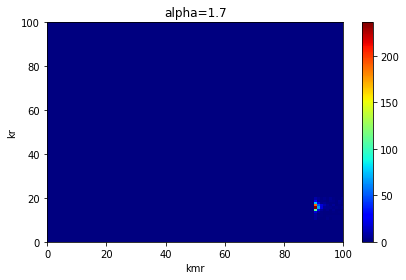

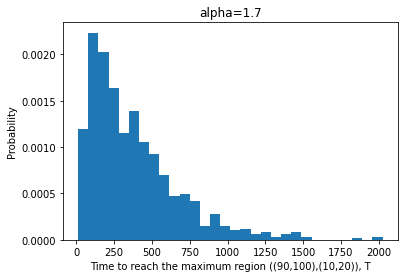

alpha = 0.1
D = 2
gamma = 1
dt = 0.1
minDt = 0
eta = 0.1
T = 5000
t0 = 0
x0 = 5
y0 = 5
potential_file = ./input/landscape1.csv
potential_file_second = ./input/landscape2.csv
kmr1 = 90
kmr2 = 100
kr1 = 10
kr2 = 20
seed = 30516
Ntraj = 100
Only end points of the 100 trajectories will be printed as the output.
Running the simulation...

-------------launch_2D_ensemble_potential_file()-----------
potential_file=./input/landscape1.csv
potential_file_second=./input/landscape2.csv
Average time of simulation: 52.9728
Time simulation variance: 1977.21
Output written to STDOUT.
Done.

alpha = 0.1
D = 2
gamma = 1
dt = 0.1
minDt = 0
eta = 0.1
T = 5000
t0 = 0
x0 = 5
y0 = 5
potential_file = ./input/landscape1.csv
potential_file_second = ./input/landscape2.csv
kmr1 = 90
kmr2 = 100
kr1 = 10
kr2 = 20
seed = 32143
Ntraj = 100
Only end points of the 100 trajectories will be printed as the output.
Running the simulation...

-------------launch_2D_ensemble_potential_file()-----------
potential_file=./input

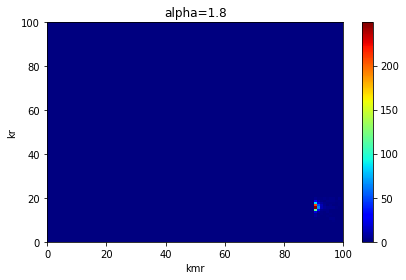

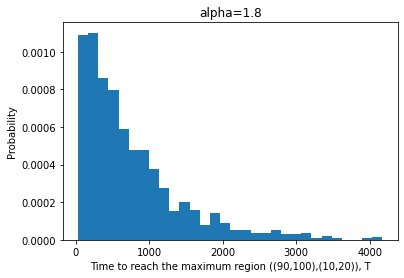

alpha = 0.1
D = 2
gamma = 1
dt = 0.1
minDt = 0
eta = 0.1
T = 5000
t0 = 0
x0 = 5
y0 = 5
potential_file = ./input/landscape1.csv
potential_file_second = ./input/landscape2.csv
kmr1 = 90
kmr2 = 100
kr1 = 10
kr2 = 20
seed = 30516
Ntraj = 100
Only end points of the 100 trajectories will be printed as the output.
Running the simulation...

-------------launch_2D_ensemble_potential_file()-----------
potential_file=./input/landscape1.csv
potential_file_second=./input/landscape2.csv
Average time of simulation: 52.9728
Time simulation variance: 1977.21
Output written to STDOUT.
Done.

alpha = 0.1
D = 2
gamma = 1
dt = 0.1
minDt = 0
eta = 0.1
T = 5000
t0 = 0
x0 = 5
y0 = 5
potential_file = ./input/landscape1.csv
potential_file_second = ./input/landscape2.csv
kmr1 = 90
kmr2 = 100
kr1 = 10
kr2 = 20
seed = 32143
Ntraj = 100
Only end points of the 100 trajectories will be printed as the output.
Running the simulation...

-------------launch_2D_ensemble_potential_file()-----------
potential_file=./input

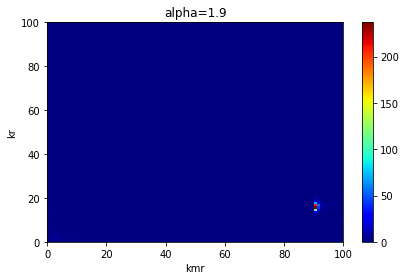

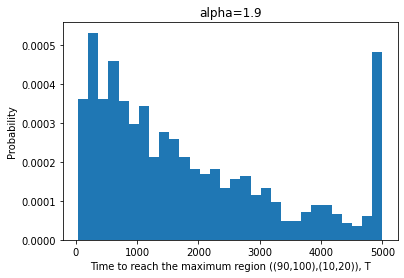

In [11]:
T=5000.
Ntraj=1000

data=[]
for alpha in np.arange(0.1,2.0,0.1):
    output_data_file=run_ensemble_simulation(alpha, T=T, Ntraj=Ntraj)
    plot_heatmap(output_data_file=output_data_file, alpha=alpha)
    plot_fpt_hist(output_data_file=output_data_file, alpha=alpha)
    mean_fpt, sd_fpt=get_fpt_mean_sd(output_data_file=output_data_file)
    data.append([alpha, mean_fpt,sd_fpt])

mfptdf=pd.DataFrame(data, columns=['alpha', 'mean_fpt','sd_fpt'])

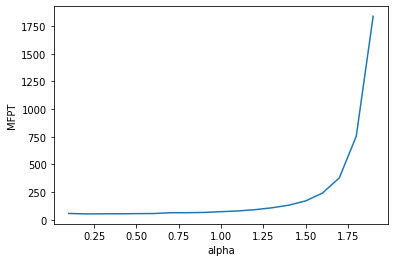

In [12]:
fig,ax=plt.subplots(1,1)
ax.plot(mfptdf['alpha'],mfptdf['mean_fpt'])
ax.set_xlabel('alpha')
ax.set_ylabel('MFPT')
plt.show()